# Face detection

Convolutional neural networks (CNNs) are an effective tool for building facial-recognition models. They're trained with images in which each face is carefully cropped and aligned in the frame. Suppose you wanted to tag people in photos uploaded to a Web site. Before submitting faces to the model for identification, you first need to find the faces in the photos, a process known as *face detection*. Detecting faces like the ones in the photo below is a necessary component of an end-to-end facial-recognition system.

![](Images/winsummit.png)

This notebook introduces two widely used algorithms for face detection – one that relies on machine learning, and another that uses deep learning – as well as Python libraries that implement them.

## Face detection with Viola-Jones

One of the fastest and most popular algorithms for detecting faces in photos stems from a paper published in 2001 entitled [Rapid Object Detection using a Boosted Cascade of Simple Features](https://www.merl.com/publications/docs/TR2004-043.pdf). Sometimes known as Viola-Jones (the authors of the paper), the algorithm keys on the relative intensities of adjacent blocks of pixels. For example, the average pixel intensity in a rectangle around the eyes is typically darker than the average pixel intensity in a rectangle immediately below. Similarly, the bridge of the nose is usually lighter than the region around the eyes, so two dark rectangles with a bright rectangle in the middle might represent two eyes and a nose. The presence of many such [Haar-like features](https://en.wikipedia.org/wiki/Haar-like_feature) in a frame at the right locations is a strong indicator that the frame contains a face.

[OpenCV](https://opencv.org/) provides an implementation of Viola-Jones in its [`CascadeClassifier`](https://docs.opencv.org/3.4.3/d1/de5/classcv_1_1CascadeClassifier.html) class, along with an XML file containing a cascade classifier trained to detect faces. The following statements use `CascadeClassifier` to detect faces in an image and draw rectangles around the faces:

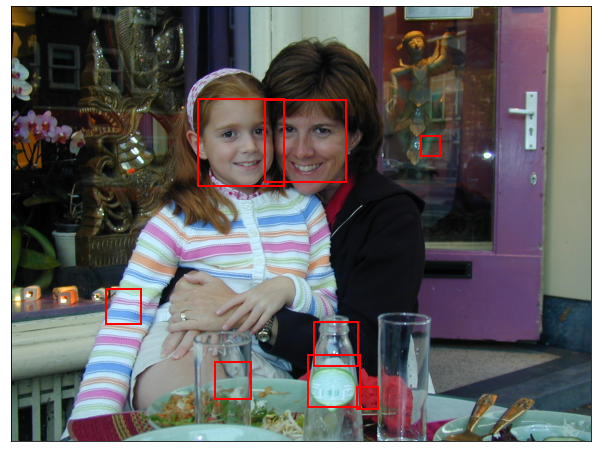

In [1]:
import cv2
from cv2 import CascadeClassifier
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
 
image = plt.imread('Data/lori-abby.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)
 
model = CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = model.detectMultiScale(image)
 
for face in faces:
    x, y, w, h = face
    rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    ax.add_patch(rect)

`CascadeClassifier` detected the two faces in the photo, but it also suffered a number of false positives. One way to mitigate that is to use the `minNeighbors` parameter. It defaults to 3, but higher values make `CascadeClassifier` less aggressive in finding faces. With `minNeighbors`=20, `detectMultiScale` finds just the two faces in the photo:

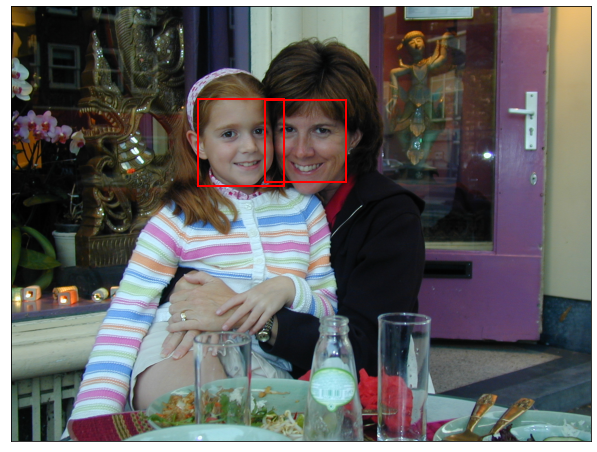

In [2]:
image = plt.imread('Data/lori-abby.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)
 
model = CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = model.detectMultiScale(image, minNeighbors=20)
 
for face in faces:
    x, y, w, h = face
    rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    ax.add_patch(rect)

`CascadeClassifier` frequently requires tuning in this manner to strike the right balance between finding too many faces and finding too few. With that in mind, it is among the fastest face-detection algorithms in existence. It can also be used to detect objects other than faces by loading XML files containing other pretrained classifiers. Here’s a [list of XML files](https://github.com/opencv/opencv/tree/master/data/haarcascades) included with OpenCV that detect objects using Haar-like features, as well as a [list of XML files](https://github.com/opencv/opencv/tree/master/data/lbpcascades) that detect objects using a different type of discriminator called [local binary patterns](https://en.wikipedia.org/wiki/Local_binary_patterns).

## Face detection with MTCNNs

While more computationally expensive, deep-learning methods often do a better job of detecting faces in images than Viola-Jones. In particular, *multitask cascaded convolutional neural networks*, or MTCNNs, have proven adept at face detection in a variety of benchmarks. They also identify facial landmarks such as the eyes, the nose, and the mouth. MTCNNs were proposed in a 2016 paper entitled [Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks](https://arxiv.org/abs/1604.02878).

A handy MTCNN implementation is available in the Python package named [MTCNN](https://pypi.org/project/mtcnn/). The following statements use it to detect faces in the same photo featured in the previous example:

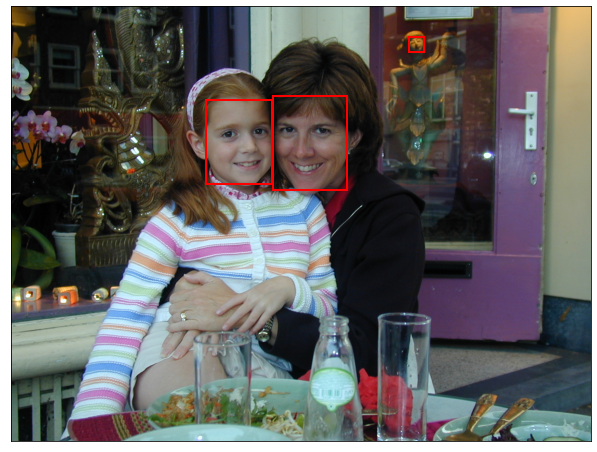

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN
%matplotlib inline
 
image = plt.imread('Data/lori-abby.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)
 
detector = MTCNN()
faces = detector.detect_faces(image)
 
for face in faces:
    x, y, w, h = face['box']
    rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    ax.add_patch(rect)

`MTCNN` not only detected the faces of the two people in the photo, but also the face of a statue reflected in the door behind them. Use the following code to see what `detect_faces` actually returned – a list containing three dictionaries, each corresponding to one of the faces in the photo:

In [4]:
print(faces)

[{'box': [723, 248, 204, 258], 'confidence': 0.9997798800468445, 'keypoints': {'left_eye': (765, 341), 'right_eye': (858, 343), 'nose': (800, 408), 'mouth_left': (770, 432), 'mouth_right': (864, 433)}}, {'box': [538, 258, 183, 232], 'confidence': 0.9997591376304626, 'keypoints': {'left_eye': (601, 353), 'right_eye': (685, 344), 'nose': (662, 394), 'mouth_left': (614, 433), 'mouth_right': (689, 424)}}, {'box': [1099, 84, 40, 41], 'confidence': 0.8863282203674316, 'keypoints': {'left_eye': (1108, 101), 'right_eye': (1123, 96), 'nose': (1116, 102), 'mouth_left': (1114, 115), 'mouth_right': (1127, 111)}}]


You can eliminate the face in the reflection in either of two ways: by ignoring faces with a confidence level below a certain threshold, or by passing a `min_face_size` parameter to the `MTCNN` function to have `detect_faces` ignore faces smaller than a specified size. Here’s an example of the former:

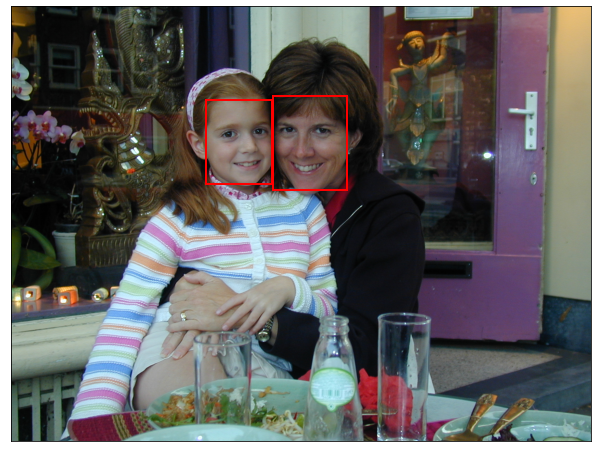

In [5]:
image = plt.imread('Data/lori-abby.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)
 
detector = MTCNN()
faces = detector.detect_faces(image)
 
for face in faces:
    if face['confidence'] > 0.9:
        x, y, w, h = face['box']
        rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
        ax.add_patch(rect)

The photo at the top of this post was generated with `MTCNN` using its default settings – that is, without any filtering based on confidence levels or face sizes. Generally speaking, it does a better job out of the box than `CascadeClassifier` at detecting faces.